# Local Outlier Factor

## Import Data

In [1]:
import pandas as pd

train_df = pd.read_csv("../data/processed_train_df.csv")
print(train_df.shape)

test_df = pd.read_csv("../data/processed_test_df.csv")
print(test_df.shape)

df = pd.concat([train_df, test_df])
print(df.shape)

(227845, 31)
(56962, 31)
(284807, 31)


In [2]:
# Exclude labels

y_train = train_df['Class']
X_train = train_df.drop(columns=['Class'])

X_train.columns

y_test = test_df['Class']
X_test = test_df.drop(columns=['Class'])

labels = df['Class']
df_unlabelled = df.drop(columns=['Class'])

## Model Building

In [3]:
from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor(
    n_neighbors=35,   # hyperparameter to tune
    novelty=True,     # allow scoring unseen data
    contamination=0.0015,  # expected fraction of anomalies (used for predict threshold only)
    n_jobs=-1
)

lof.fit(X_train)

LocalOutlierFactor(contamination=0.0015, n_jobs=-1, n_neighbors=35,
                   novelty=True)

In [4]:
scores = -lof.decision_function(X_test)
pred_labels = (lof.predict(X_test) == -1).astype(int)

c:\Users\lukeh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
c:\Users\lukeh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


ROC: 0.505
PR AUC: 0.0032


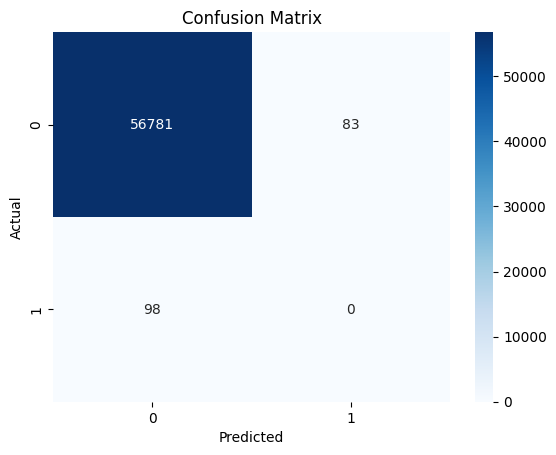

In [5]:
from sklearn.metrics import roc_auc_score, average_precision_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

roc = roc_auc_score(y_test, scores)
pr_auc = average_precision_score(y_test, scores)

print(f"ROC: {roc.round(4)}")
print(f"PR AUC: {pr_auc.round(4)}")

# Confusion Matrix
sns.heatmap(confusion_matrix(y_test, pred_labels), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

This model clearly performs terribly. Let's try tuning it.

## Hyperparameter Tuning

In [6]:
# Find a good random_state so that the sample mean is close to the actual mean

mean = 0
i = 0

while abs(mean-0.00172) > 0.00002:
    i+=1
    train_sample = train_df.sample(frac=0.5, random_state=i)
    X_sample = train_sample.drop(columns=['Class'])
    y_sample = train_sample['Class']
    mean = y_sample.mean()

print(i)
print(mean)

3
0.001738031284563122


In [7]:
import numpy as np

def precision_recall_at_k(y_true, scores, k=0.01):
    """
    Compute Precision@k and Recall@k for anomaly scores.
    y_true: array-like of shape (n,) with 0/1 labels
    scores: array-like of shape (n,) with higher = more anomalous
    k: fraction of samples to flag (e.g. 0.01 = top 1%)
    """
    n = len(scores)
    top_n = max(1, int(np.ceil(k * n)))  # at least one sample

    # Get indices of top-k scores
    idx = np.argsort(-scores)[:top_n]

    # Precision = frauds / flagged
    precision = y_true.iloc[idx].mean()

    # Recall = frauds caught / total frauds
    recall = y_true.iloc[idx].sum() / y_true.sum()

    return precision, recall

In [8]:
from sklearn.model_selection import ParameterGrid

def tune_LOF(param_grid, PRIMARY, SECONDARY, X_train=X_train, X_test=X_test, y_test=y_test):

    runs = []
    best_tuple = (-np.inf, -np.inf)
    best_params, best_model, best_scores = None, None, None

    for params in ParameterGrid(param_grid):
        lof = LocalOutlierFactor(
            novelty=True,
            n_jobs=-1,
            metric="minkowski",
            **params
        )
        lof.fit(X_train)
        scores = -lof.decision_function(X_test)

        roc = roc_auc_score(y_test, scores)
        pr_auc = average_precision_score(y_test, scores)
        p_at_1,  r_at_1  = precision_recall_at_k(y_test, scores, k=0.01)
        p_at_05, r_at_05 = precision_recall_at_k(y_test, scores, k=0.005)

        runs.append({
            **params,
            "ROC": roc,
            "pr_auc": pr_auc,
            "p_at_1": p_at_1, "r_at_1": r_at_1,
            "p_at_05": p_at_05, "r_at_05": r_at_05
        })

        primary_val   = r_at_1 if PRIMARY == "r_at_1" else pr_auc
        secondary_val = pr_auc if SECONDARY == "pr_auc" else r_at_1

        if (primary_val, secondary_val) > best_tuple:
            best_tuple  = (primary_val, secondary_val)
            best_params = params
            best_model  = lof
            best_scores = scores

    results_df = pd.DataFrame(runs).sort_values(
        by=[PRIMARY, SECONDARY], ascending=[False, False]
    ).reset_index(drop=True)

    print("Top configs:")
    display(results_df.head(10))
    print("\nSelected params:", best_params)
    print(f"Selected {PRIMARY}={best_tuple[0]:.4f}, {SECONDARY}={best_tuple[1]:.4f}")

    return(best_tuple, best_params, best_model, best_scores)

In [ ]:
PRIMARY   = "r_at_1"
SECONDARY = "pr_auc"

param_grid = {
    "n_neighbors": [100, 200, 300], # Narrowed down through multiple iterations
}

# First tune on a sample of the train dataset
tune_LOF(param_grid, PRIMARY, SECONDARY, X_sample)

c:\Users\lukeh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
c:\Users\lukeh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
c:\Users\lukeh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


Top configs:


,n_neighbors,ROC,pr_auc,p_at_1,r_at_1,p_at_05,r_at_05
0,300,0.950091,0.488609,0.143860,0.836735,0.280702,0.816327
1,200,0.952809,0.339831,0.143860,0.836735,0.266667,0.775510
2,100,0.812092,0.040605,0.042105,0.244898,0.063158,0.183673



Selected params: {'n_neighbors': 300}
Selected r_at_1=0.8367, pr_auc=0.4886


((0.8367346938775511, 0.4886089523976214),
 {'n_neighbors': 300},
 LocalOutlierFactor(n_jobs=-1, n_neighbors=300, novelty=True),
 array([-0.48096759, -0.12858447,  0.11515599, ..., -0.31406179,
        -0.52602916, -0.38971367]))

In [10]:
PRIMARY   = "r_at_1"
SECONDARY = "pr_auc"

param_grid = {
    "n_neighbors": [300, 400, 500], # Narrowed down through multiple iterations
}

# Try tuning on the whole train dataset
tune_LOF(param_grid, PRIMARY, SECONDARY)

c:\Users\lukeh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
c:\Users\lukeh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
c:\Users\lukeh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


Top configs:


,n_neighbors,ROC,pr_auc,p_at_1,r_at_1,p_at_05,r_at_05
0,500,0.951594,0.452135,0.143860,0.836735,0.277193,0.806122
1,400,0.953352,0.355184,0.143860,0.836735,0.266667,0.775510
2,300,0.944919,0.129303,0.091228,0.530612,0.122807,0.357143



Selected params: {'n_neighbors': 500}
Selected r_at_1=0.8367, pr_auc=0.4521


((0.8367346938775511, 0.45213473919740216),
 {'n_neighbors': 500},
 LocalOutlierFactor(n_jobs=-1, n_neighbors=500, novelty=True),
 array([-0.48268074, -0.14050481,  0.0793722 , ..., -0.33649075,
        -0.52684977, -0.38207182]))

It looks like p_at_1 and r_at_1 have stopped improving at n=400, but let's see if we can further improve the PR AUC by using even more neighbours.

In [11]:
PRIMARY   = "r_at_1"
SECONDARY = "pr_auc"

param_grid = {
    "n_neighbors": [500, 625, 750], # Narrowed down through multiple iterations
}

# First tune on a sample of the train dataset
tune_LOF(param_grid, PRIMARY, SECONDARY, X_sample)

c:\Users\lukeh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
c:\Users\lukeh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
c:\Users\lukeh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


Top configs:


,n_neighbors,ROC,pr_auc,p_at_1,r_at_1,p_at_05,r_at_05
0,500,0.951081,0.508509,0.145614,0.846939,0.277193,0.806122
1,625,0.953682,0.498440,0.145614,0.846939,0.277193,0.806122
2,750,0.955542,0.490883,0.145614,0.846939,0.273684,0.795918



Selected params: {'n_neighbors': 500}
Selected r_at_1=0.8469, pr_auc=0.5085


((0.8469387755102041, 0.508508803405223),
 {'n_neighbors': 500},
 LocalOutlierFactor(n_jobs=-1, n_neighbors=500, novelty=True),
 array([-0.44120352, -0.10135555,  0.14755746, ..., -0.27851588,
        -0.52519271, -0.40563067]))

In [12]:
PRIMARY   = "r_at_1"
SECONDARY = "pr_auc"

param_grid = {
    "n_neighbors": [500, 625, 750], # Narrowed down through multiple iterations
}

# Try tuning on the whole train dataset
tune_LOF(param_grid, PRIMARY, SECONDARY)

c:\Users\lukeh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
c:\Users\lukeh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
c:\Users\lukeh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


Top configs:


,n_neighbors,ROC,pr_auc,p_at_1,r_at_1,p_at_05,r_at_05
0,750,0.949320,0.512600,0.14386,0.836735,0.280702,0.816327
1,625,0.949751,0.508164,0.14386,0.836735,0.280702,0.816327
2,500,0.951594,0.452135,0.14386,0.836735,0.277193,0.806122



Selected params: {'n_neighbors': 750}
Selected r_at_1=0.8367, pr_auc=0.5126


((0.8367346938775511, 0.512600281871914),
 {'n_neighbors': 750},
 LocalOutlierFactor(n_jobs=-1, n_neighbors=750, novelty=True),
 array([-0.46235842, -0.12872739,  0.12935556, ..., -0.30954644,
        -0.52767309, -0.39443168]))

It appears as though the improvements in p_at_05, r_at_05 and PR AUC have now become minute for the additional neighbors.

Now let's try out some of the best parameters on the test set to see how effective they are on the whole dataset.

## Validation

In [11]:
n = 600

lof = LocalOutlierFactor(
    n_neighbors=n,
    novelty=True,
    n_jobs=-1,
    metric="minkowski"
)

lof.fit(X_train)

scores = -lof.decision_function(df_unlabelled)

roc = roc_auc_score(labels, scores)
pr_auc = average_precision_score(labels, scores)
p_at_1,  r_at_1  = precision_recall_at_k(labels, scores, k=0.01)
p_at_05, r_at_05 = precision_recall_at_k(labels, scores, k=0.005)

print({
    "n_neighbors": n,
    "ROC": roc,
    "pr_auc": pr_auc,
    "p_at_1": p_at_1, "r_at_1": r_at_1,
    "p_at_05": p_at_05, "r_at_05": r_at_05
})

c:\Users\lukeh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


{'n_neighbors': 600, 'ROC': 0.9600119614266154, 'pr_auc': 0.45064662049874277, 'p_at_1': 0.1418041418041418, 'r_at_1': 0.8211382113821138, 'p_at_05': 0.27649122807017545, 'r_at_05': 0.8008130081300813}


Note that these scores can be marginally improved upon by setting a higher n_neighbors, but the improvements are marginal compared to the computational cost.

Our tuned Local Outlier Factor (LOF) model achieved ROC AUC = 0.96 and PR AUC = 0.45, substantially higher than the Isolation Forest baseline.

At a 1% review budget, the model reached 14% precision and 82% recall, representing an ~83× improvement over random guessing.
In practice, this means fraud investigators could detect ~404 fraud cases (over 80% of all frauds in the dataset) while only reviewing 1% of transactions.

At a 0.5% review budget, the model achieved 28% precision and 80% recall, a ~162× improvement over random guessing.
This translates to catching ~394 fraud cases (around 80% of the total) while reviewing just 0.5% of transactions (~1,425 cases out of 285,000).

## Reducing Model Complexity

In practice, it is feasible that increased PR AUC is not deemed to be worth the extra computational cost that comes with it, as only the top x% of transactions flagged as 'most suspicious' will be manually reviewed.

In this case, can we simplify the model so that it runs more efficiently, whilst maintaining good p_at_1 and r_at_1 scores?

Note that this assumes that the top 1% of transactions will be reviewed. Of course, if the percentage differs from 1% that would affect the model complexity necessary to retain performance.

In [9]:
PRIMARY   = "r_at_1"
SECONDARY = "pr_auc"

param_grid = {
    "n_neighbors": [300, 350, 400], # Narrowed down through multiple iterations
}

tune_LOF(param_grid, PRIMARY, SECONDARY, X_train, df_unlabelled, labels)

c:\Users\lukeh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
c:\Users\lukeh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
c:\Users\lukeh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


Top configs:


,n_neighbors,ROC,pr_auc,p_at_1,r_at_1,p_at_05,r_at_05
0,400,0.958463,0.323934,0.141453,0.819106,0.265965,0.770325
1,350,0.957146,0.217713,0.133731,0.774390,0.225263,0.652439
2,300,0.947388,0.120115,0.092313,0.534553,0.136842,0.396341



Selected params: {'n_neighbors': 400}
Selected r_at_1=0.8191, pr_auc=0.3239


((0.8191056910569106, 0.3239339297415811),
 {'n_neighbors': 400},
 LocalOutlierFactor(n_jobs=-1, n_neighbors=400, novelty=True),
 array([-0.47846327, -0.48865171, -0.36798745, ..., -0.34782958,
        -0.5274536 , -0.3745834 ]))

In [12]:
PRIMARY = "r_at_1"
SECONDARY = "pr_auc"

runs = []
best_tuple = (-np.inf, -np.inf)
best_n, best_model, best_scores = None, None, None

for n in [300, 350, 400]:

    lof = LocalOutlierFactor(
        n_neighbors=n,
        novelty=True,
        n_jobs=-1,
        metric="minkowski"
    )

    lof.fit(X_train)

    scores = -lof.decision_function(df_unlabelled)

    roc = roc_auc_score(labels, scores)
    pr_auc = average_precision_score(labels, scores)
    p_at_1,  r_at_1  = precision_recall_at_k(labels, scores, k=0.01)
    p_at_05, r_at_05 = precision_recall_at_k(labels, scores, k=0.005)

    runs.append({
        "n_neighbors": n,
        "ROC": roc,
        "pr_auc": pr_auc,
        "p_at_1": p_at_1, "r_at_1": r_at_1,
        "p_at_05": p_at_05, "r_at_05": r_at_05
    })

    primary_val   = r_at_1 if PRIMARY == "r_at_1" else pr_auc
    secondary_val = pr_auc if SECONDARY == "pr_auc" else r_at_1

    if (primary_val, secondary_val) > best_tuple:
        best_tuple  = (primary_val, secondary_val)
        best_n = n
        best_model  = lof
        best_scores = scores

results_df = pd.DataFrame(runs).sort_values(
    by=[PRIMARY, SECONDARY], ascending=[False, False]
).reset_index(drop=True)

print("Top configs:")
display(results_df.head(10))
print("\nSelected n_neighbors:", best_n)
print(f"Selected {PRIMARY}={best_tuple[0]:.4f}, {SECONDARY}={best_tuple[1]:.4f}")

c:\Users\lukeh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
c:\Users\lukeh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
c:\Users\lukeh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


Top configs:


,n_neighbors,ROC,pr_auc,p_at_1,r_at_1,p_at_05,r_at_05
0,400,0.958463,0.323934,0.141453,0.819106,0.265965,0.770325
1,350,0.957146,0.217713,0.133731,0.774390,0.225263,0.652439
2,300,0.947388,0.120115,0.092313,0.534553,0.136842,0.396341



Selected n_neighbors: 400
Selected r_at_1=0.8191, pr_auc=0.3239


We can see that reducing n_neighbors to 400, we can retain strong p_at_1 and r_at_1 values whilst reducing model complexity.